In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

For object detection group 1 members:
please read the comments at the beginning for each block before running the codes!

In [2]:
# first upload the car data set
# then connecting to your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# if you are using another version yolo, find the corresponding link
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 10496, done.
remote: Total 10496 (delta 0), reused 0 (delta 0), pack-reused 10496
Receiving objects: 100% (10496/10496), 10.66 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (7257/7257), done.
     |████████████████████████████████| 106 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=265212 sha256=e310db07b34de68da2f6135baf3803239c4b8a818d65fb9861cc97f89b87c492
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.3
    Uninstalling pycocotools-2.0.3:
      Successfully uninstalled pycocotools-2.0.3
     |████████████████████████████████| 596 kB 4.9 MB/s 
CPU times: user 158 ms, sys: 5

In [4]:
# this block aims to extract the x_center, y_center, w, h for the bounding box, yolo models need them as the input
# in the future, if you want to use other datasets, also need to extract these 4 features
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/drive/MyDrive/TUM/assigenment2/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764800,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020261,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [5]:
# just sample one to see
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/drive/MyDrive/TUM/assigenment2/car-object-detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_26360


(380, 676, 3)

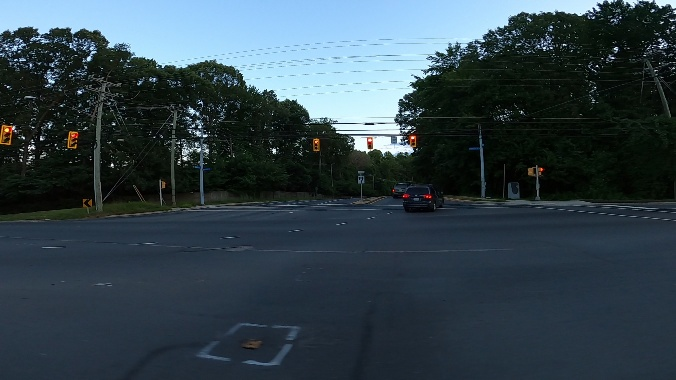

In [6]:
# just sample one to see
image = random.choice(index)
Image(filename=f'/content/drive/MyDrive/TUM/assigenment2/car-object-detection/data/training_images/{image}.jpg',width=600)

In [7]:
# This block aims to generate txt files containing x_center, y_center, w, h and class (in this case, we only have one class, namely binary: is it a car or not?). 
# After running this block, you should see another 2 folders were created in your googlecolab page (left)
# The inputs for yolov5 are: 1. Image  2. txt files containing information as mentioned above
# you need to change the path where your dataset is (the last line: "/content/drive/MyDrive/TUM/assigenment2/car-object-detection/data/{}/{}.jpg")
# you don't need to change the other paths from other lines ('/content/tmp/convertor/fold{}/labels/')
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/content/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/content/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/content/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/MyDrive/TUM/assigenment2/car-object-detection/data/{}/{}.jpg".format(source,name),'/content/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))


  0%|          | 0/355 [00:00<?, ?it/s]

In [ ]:
# .yaml example: (not run)
# below just showed the official .yaml for coco128 dataset
# you can find my car.yaml dataset, you need to change the train path and the val path where you stored your dataset in your drive

path: ../datasets/coco128  # dataset root dir (you can delete it if you included the whole absolute path in the lines below)
train: images/train2017  # train images 
val: images/train2017  # val images 
test:  # test images (optional)

# coco128 has 80 classes, here we only have 1 class: car, in the future you can change it based on your dataset
nc: 80  # number of classes
names: [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]  # class names

In [9]:
# running the training procedure
!python /content/yolov5/train.py --batch 4 --epochs 30 --data /content/drive/MyDrive/TUM/assigenment2/car.yaml --cfg /content/drive/MyDrive/TUM/assigenment2/yolov5s.yaml
# once the training is done, your weights will be stored in 'yolov5/runs/train/exp' (googlecolab page on the left)

train: weights=yolov5/yolov5s.pt, cfg=/content/drive/MyDrive/TUM/assigenment2/yolov5s.yaml, data=/content/drive/MyDrive/TUM/assigenment2/car.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-184-g6865d19 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_

In [13]:
# after you trained the model from above, use the .pt (weights) you stored to apply on the new dataset
# simply change the source path as what you want to test (you can download a video or other car images from anywhere)
!python yolov5/detect.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --conf 0.3 --source /content/drive/MyDrive/TUM/assigenment2/uspolicecar.mp4
# conf:置信区间 越小 框越多越不准/conf smaller, less accurate
# detect里 source的default改成"0"就是摄像头/if set source default in the detect.py code as 0, use the real-time camera
# if: "yolo" RuntimeError: Given groups=1, weight of size expected input -> change train.py https://blog.csdn.net/qq_43533724/article/details/121743384 (one bug I found)

detect: weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], source=/content/drive/MyDrive/TUM/assigenment2/uspolicecar.mp4, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-184-g6865d19 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/304) /content/drive/MyDrive/TUM/assigenment2/uspolicecar.mp4: 384x640 7 cars, Done. (0.030s)
video 1/1 (2/304) /content/drive/MyDrive/TUM/assigenment2/uspolicecar.mp4: 384x640 8 cars, Done. (0.018s)
video 1/1 (3/304) /content/drive/MyDrive/TUM/assigenment2/uspolicecar.mp4: 384x640 7

In [20]:
# not a must to run here, you can download the processed video/image from 'yolov5/runs/detect/exp'
# below is just a display code for mp4 on googlecolab
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

video_path = "/content/yolov5/runs/detect/exp2/160820_052_NYC_TaxisInRain2_1080p.mp4"
show_video(video_path)